In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def f(x):
    return 3*x**2 - 4*x+5

In [4]:
f(3.0)

20.0

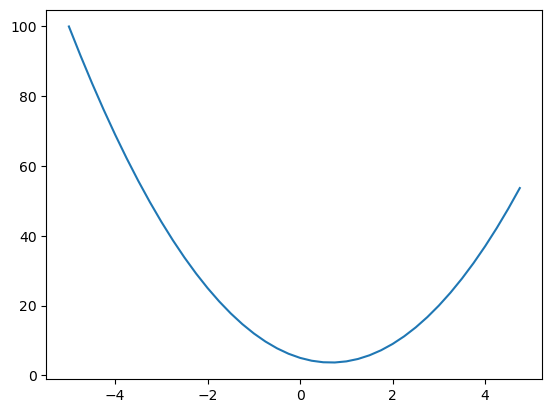

In [5]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)
plt.show()

In [6]:
h=0.000000001
x=2/3
(f(x+h)-f(x))/h

0.0

In [7]:
a=2.0
b=-3.0
c=10.0
d1=a*b+c
d1

4.0

In [8]:
b+=h
d2=a*b+c
d2


4.000000002

In [9]:
(d2-d1)/h

2.000000165480742

In [33]:
class Value:

    def __init__(self,data,_childern=(),_op=' ',label=''):
        self.data=data
        self.grad=0.0
        self._backward=lambda :None 
        self._prev=set(_childern)
        self._op=_op
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data + other.data,(self,other),'+')

        def _backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        return out
        
    def __radd__(self, other): # other + self
        return self + other


    def __neg__(self):
        return self*-1

    def __sub__(self,other):
        return self+(-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
        
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad=other.data*out.grad
            other.grad=self.data*out.grad
        out._backward=_backward
        return out

    def __rmul__(self,other):  # other*self
        return self*other 

    def tanh(self):
       x=self.data
       t=(math.exp(x*2)-1)/(math.exp(x*2)+1)
       out=Value(t,(self,),'tanh')
       def _backward():
            self.grad+=(1-t*t)*out.grad
       out._backward=_backward
       
    
       return out

    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward

        return out

    def __truediv__(self,other): #self/other 
        return self*other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __pow__(self,other):
        assert isinstance(other, (int,float)),"Only supporting int/float powers for now "
        x=self.data
        out=Value(x**other,(self,),f'**{other}')
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward

        return out
        

    def backward(self):
        
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1
        for node in reversed(topo):
            node._backward()
        


a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b; e.label='e'
d=e+c  #(a.__mul__(b)).__add__(c) this is the output if we dont use the repr function 
d.label='d'
f=Value(-2.0,label='f')
L=d*f
L.label='L'
a*b-2

Value(data=-8.0)

In [11]:
a=Value(2.0)
b=Value(4.0)
a+1

Value(data=3.0)

In [12]:
d._prev # givews vals previous to d that is a*b and c

{Value(data=-6.0), Value(data=10.0)}

In [13]:
d._op

'+'

In [14]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [15]:
#manual backprop 
L.grad=1.0
d.grad=f.data
f.grad=d.data
c.grad=f.data
e.grad=f.data
a.grad=f.data*b.data
b.grad=f.data*a.data

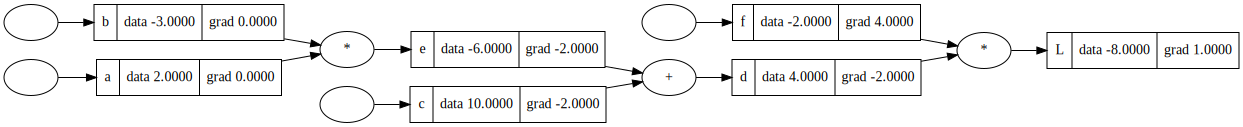

In [16]:
draw_dot(L)

In [17]:
# now if we want L to go upwards we just have to go in the direction of the gradient 
a.data+=0.001*a.grad
b.data+=0.001*b.grad
c.data+=0.001*c.grad
f.data+=0.001*f.grad
e=a*b
d=e+c
L=f*d
L

Value(data=-35.844231872)

In [18]:
def prac():
 h=0.00000001
 a=Value(2.0,label='a')
 b=Value(-3.0,label='b')
 c=Value(10.0,label='c')
 e=a*b; e.label='e'
 d=e+c  #(a.__mul__(b)).__add__(c) this is the output if we dont use the repr function 
 d.label='d'
 f=Value(-2.0,label='f')
 L=d*f
 L1=L.data

 a=Value(2.0,label='a')
 b=Value(-3.0,label='b')
 c=Value(10.0+h,label='c')
 e=a*b; e.label='e'
 d=e+c  #(a.__mul__(b)).__add__(c) this is the output if we dont use the repr function 
 d.label='d'
 f=Value(-2.0,label='f')
 L=d*f
 L2=L.data

 return (L2-L1)/h


prac()  

-2.000000165480742

In [19]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
b=Value(6.88137,label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2= x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b ; n.label='n'
o=n.tanh();o.label='o'


In [20]:
# #manual grads
# o.grad=1
# n.grad=1-(n.tanh().data*n.tanh().data) # or 1-(o.data*o.data)
# b.grad=n.grad
# x1w1x2w2.grad=n.grad # as due to + operator the gradienrs will simply flow to b and x1w1x2w2 as dn/db=1 and same for x1w1x2w2
# x1w1.grad=n.grad
# x2w2.grad=n.grad
# x2.grad=w2.data*x2w2.grad
# w2.grad=x2.data*x2w2.grad
# x1.grad=w1.data*x1w1.grad
# w1.grad=x1.data*x1w1.grad
# draw_dot(o)

In [21]:
# # backprop functionized 
# o.grad=1.0 # as in value class grad is initaially set as zero
# o._backward()
# n._backward()
# b._backward() # will have no affect as its a leaflet 
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# draw_dot(o)


In [22]:
# #backprop funcionized,sorted and looped 
# o.grad=1
# topo=[]
# visited=set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)

# build_topo(o)

# for n in reversed(topo):
#     n._backward()

# draw_dot(o)

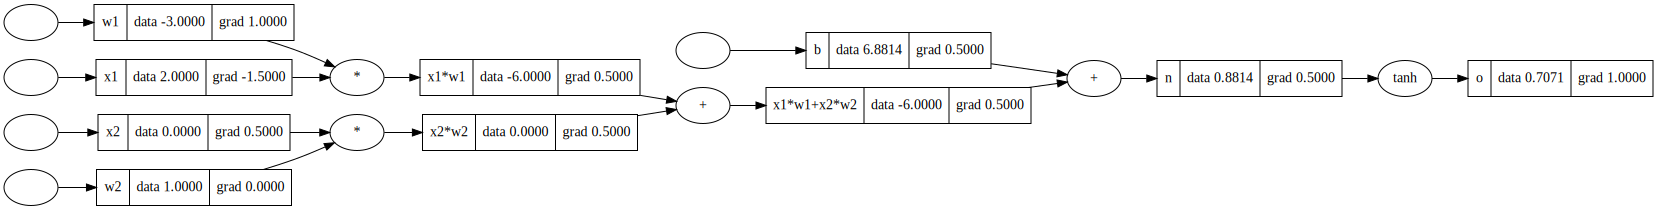

In [23]:
o.backward()
draw_dot(o)

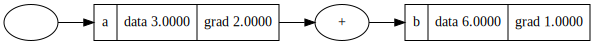

In [24]:
a=Value(3.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)


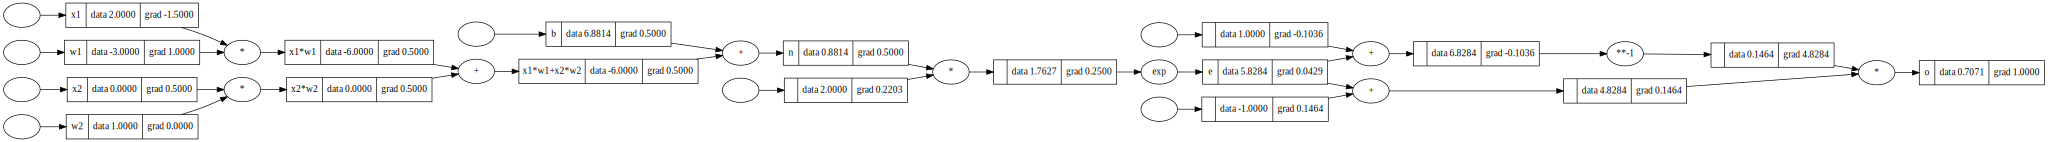

In [25]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
b=Value(6.88137,label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2= x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b ; n.label='n'
e=(2*n).exp();e.label='e'
o=(e-1)/(e+1);o.label='o'
o.backward()
draw_dot(o)

In [246]:
class Neuron:
    def __init__(self,n_in):
        self.w=[Value(random.uniform(-1,1)) for _ in range(n_in)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        activation= sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=activation.tanh()
        return out

    def paramaters(self):
        return self.w+[self.b]

class Layer:
    def __init__(self,n_in,n_out):
        self.neurons=[Neuron(n_in) for _ in range(n_out)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def paramaters(self):
        params=[p for n in self.neurons for p in n.paramaters() ]
        # for neuron in self.neurons:
        #     ps=neuron.paramaters()
        #     prams.extend(ps)
        return params 

class MLP:
    def __init__(self,n_in,nouts):
        sz=[n_in]+nouts 
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def paramaters (self):
        return [p for layer in self.layers for p in layer.paramaters()]
        

x=[2.0,3.0,-1]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.46389674308518203)

In [27]:
# draw_dot(n(x))

In [247]:
len(n.paramaters())

41

In [248]:
xs=[
    [2.0,3.0,-1],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1,01.0,-1.0]
]

ys=[1.0,-1.0,-1.0,1.0] # desired targets


In [249]:
loss_list=[]
for k in range(2000):
    y_pred=[n(x) for x in xs]
    loss=sum(((y-y_out)**2 for y,y_out in zip(ys,y_pred)))
    for p in n.paramaters():
        p.grad=0
    loss.backward()
    loss_list.append(loss.data)
    for p in n.paramaters():
        p.data+= -0.01*p.grad
    if k%100==0:
        print(k,loss.data)

0 4.428361507162345
100 0.48415345667588977
200 0.16632769310823547
300 0.08673366466057784
400 0.061819304407383084
500 0.046125349151163376
600 0.03812265982727887
700 0.03120130229670459
800 0.026263213488597656
900 0.022615211231130965
1000 0.01971314728682468
1100 0.0174397177903129
1200 0.015858774321250307
1300 0.014366997980114976
1400 0.013184450004903672
1500 0.012084287222776158
1600 0.011247990228286944
1700 0.010260636884051213
1800 0.009585778484674994
1900 0.009036012073278175


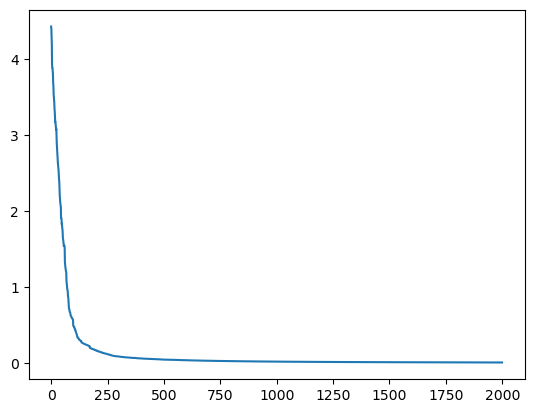

In [250]:
plt.plot(loss_list)
plt.show()

In [251]:
y_pred=[n(x) for x in xs]
y_pred

[Value(data=0.940786950224212),
 Value(data=-0.967011917530047),
 Value(data=-0.9445505715377708),
 Value(data=0.9710290978558489)]

In [ ]:
# loss.backward()

# n.layers[0].neurons[0].w[0].grad

# n.layers[0].neurons[0].w[0].data

# # draw_dot(loss)

# for p in n.paramaters():
#     p.data+= -0.05*p.grad

# n.layers[0].neurons[0].w[0].data